Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 7.  Winter 2026.

# Ridge Regression

With polynomial regression we saw that overfitting could be a problem.  Ridge regression offers a way to automatically reduce the magnitude of the fitted parameters.  This helps reduce variance and give more resilient fits.  

With standard least squares regression we are minimizing the difference between the model's prediction and the actual values, $||\mathbf{X}\boldsymbol{\beta} - \mathbf{y} ||_{2}^{2}$.  With standard least squares regression, the solution for the parameters is $\boldsymbol{\beta}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$.  With ridge regression we add a penalty to our objective function, $||\mathbf{X}\boldsymbol{\beta} - \mathbf{y}||_{2}^{2} + \lambda||\boldsymbol{\beta}||_{2}^{2}$ and the solution is $\boldsymbol{\beta}=(\mathbf{X}^{T}\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^{T}\mathbf{y}$.  Here $\lambda$ is the ridge parameter, a hyperparameter, that we can change to adjust the strength of the regularization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn

 We'll demonstate this on the volcano plot data from last time.  Here, $\log(i_{0})$ is a measure of the speed of the reaction, $\Delta G$ is the surface adsorption energy, and each data point represents a different metallic catalytic surface.

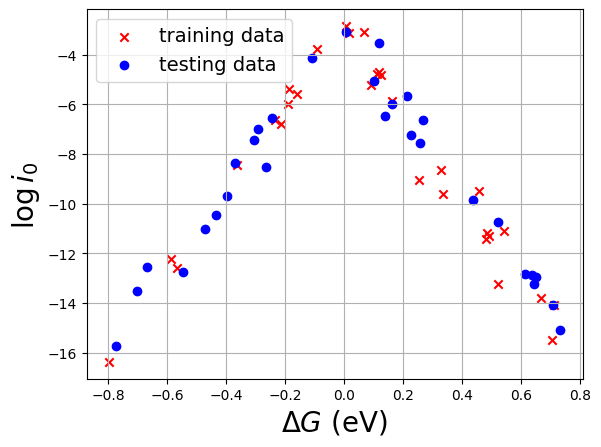

In [ ]:
#load training data
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_train.csv')
x_train = df_train[['dG (eV)']].values
y_train = df_train['Log(i0)'].values


#load testing data
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_test.csv')
x_test = df_test[['dG (eV)']].values
y_test = df_test['Log(i0)'].values


#visualize the data
fig,ax = plt.subplots()
def plot_data(ax, df, c, m, l):
  ax.scatter(df['dG (eV)'], df['Log(i0)'], color=c, marker=m, label=l)
  ax.set_xlabel('$\\Delta G$ (eV)',fontsize=20)
  ax.set_ylabel('$\\log{i_0}$',fontsize=20)

plot_data(ax, df_train, 'r', 'x', 'training data')
plot_data(ax, df_test, 'b', 'o', 'testing data')
ax.grid()
ax.legend(fontsize=14)
plt.show()

We know that fitting with a high-degree polynomial is a bad idea.  Let's remind ourselves why.  Here's a 20$^{th}$-order polynomial fit to the training data.

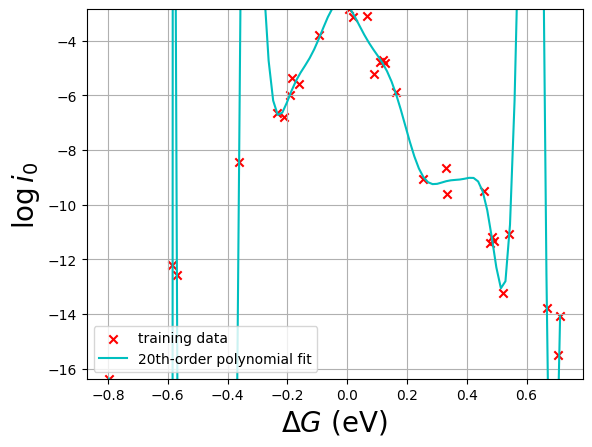

In [ ]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=20, include_bias=False)
X_train = poly_features.fit_transform(x_train)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

plot_x = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]), 100)
plot_x_poly = poly_features.transform(plot_x.reshape(-1,1))
plot_y = model.predict(plot_x_poly)

fig,ax = plt.subplots()
plot_data(ax, df_train, 'r', 'x', 'training data')
ax.plot(plot_x, plot_y, color='c', label='20th-order polynomial fit')
ax.set_ylim(np.min(y_train), np.max(y_train))
ax.grid()
ax.legend()
plt.show()

Now we'll apply ridge regularization.  When doing regularization its often a good idea to standardize our data.  This means that for each feature we subtract its mean and then divide by its standard deviation, $x \to (x - \mu)/\sigma$.  This makes all of the features roughly the same size and the fitted coefficients will be roughly the same size as well.  For features across different orders of magnitude or with different units, regularization might affect features unevenly if they are not standardized.  Standardization is a good practice across a range of machine learning techniques.

In [ ]:
#build the polynomial features for the training and test data
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=20, include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)
X_test = poly_features.transform(df_test[['dG (eV)']].values)

#here's an example for manually standardizing the data
mean = np.mean(X_train, axis=0) #calculate the mean of each feature
std = np.std(X_train, axis=0) #calculate the std. dev. of each feature

#apply the standardization to the training and test data
X_train_standardized = (X_train - mean) / std
X_test_standardized = (X_test - mean) / std

<code>sklearn</code> also has its own built-in function for doing this, which can be more convenient.

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

The <code>alpha</code> keyword in <code>sklearn</code>'s is the $\lambda$ parameter from our mathematical derivation.  Let's test a range of ridge parameters and caculate the test and training MSE along the way.  We'll also store our fitted model parameters.

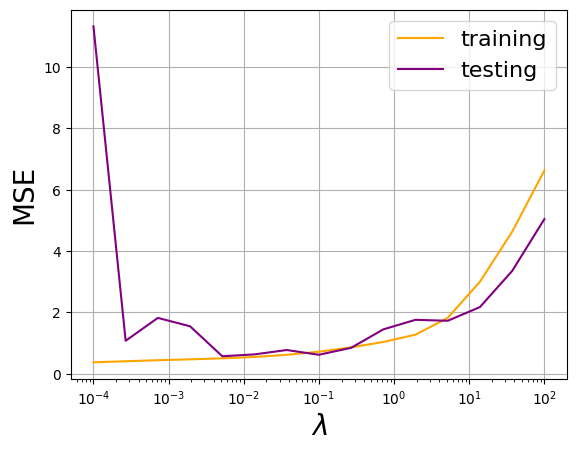

In [ ]:
#choose a range of lambda values across several orders of magnitude
lambdas = np.logspace(-4,2,15)

training_mse = []
testing_mse = []
parameters = []
for lam in lambdas:
  model = sklearn.linear_model.Ridge(alpha=lam)
  model.fit(X_train_standardized, y_train)

  parameters.append(model.coef_)

  y_pred = model.predict(X_train_standardized)
  mse = sklearn.metrics.mean_squared_error(y_train, y_pred)
  training_mse.append(mse)

  y_pred_test = model.predict(X_test_standardized)
  mse = sklearn.metrics.mean_squared_error(y_test, y_pred_test)
  testing_mse.append(mse)

fig,ax = plt.subplots()
ax.plot(lambdas, training_mse, color='orange', label='training')
ax.plot(lambdas, testing_mse, color='purple', label='testing')
ax.set_xlabel('$\\lambda$',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_xscale('log')
ax.legend(fontsize=16)
ax.grid()
plt.show()

The training error always gets worse as we regularize because the optimial solution is the non-regularized solution, which we are always penalizing.  However, looking at the test error we can see that as the penalty increases, the error decreases up to a point.  The penalty keeps the model from fitting the intrinsic error.  There is an optimum, after which the penalty becomes too strong and the model cannot fit properly.  Let's take a look at the parameters of our model as a function of $\lambda$.

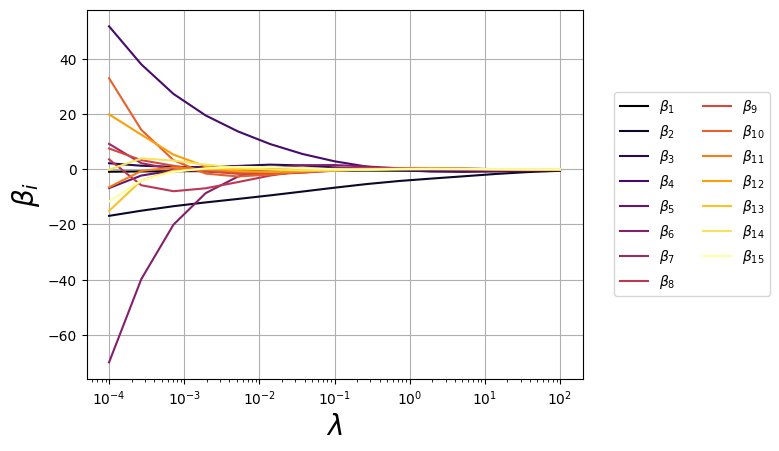

In [ ]:
parameters = np.array(parameters)

fig, ax = plt.subplots()

colormap = cm.inferno
colors = colormap(np.linspace(0.0, 1.0, parameters.shape[0]))

for i, c in enumerate(colors):
  beta = parameters[:,i]
  ax.plot(lambdas, beta, color=c, label='$\\beta_{{{}}}$'.format(i+1))

ax.set_xlabel('$\\lambda$',fontsize=20)
ax.set_ylabel('$\\beta_{i}$',fontsize=20)
ax.set_xscale('log')
ax.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.show()

As the regularization strength increases, the magnitude of the parameters decreases.  Finally, let's take a look at our model with the optimal regularization.

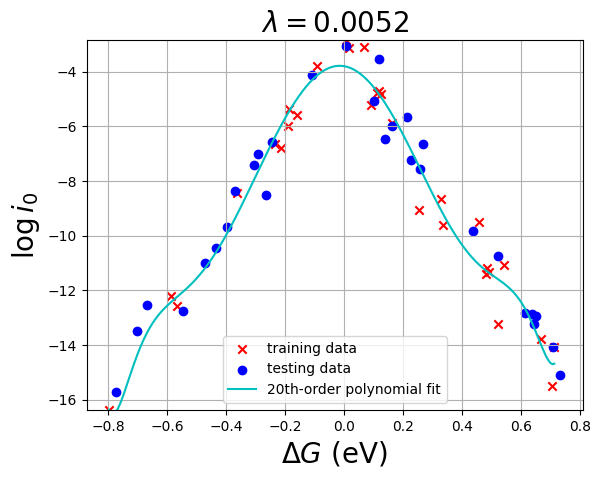

In [ ]:
idx = np.argmin(testing_mse)

model = sklearn.linear_model.Ridge(alpha=lambdas[idx])
model.fit(X_train_standardized, y_train)

xplot = np.linspace(np.min(df_train[['dG (eV)']].values), np.max(df_train[['dG (eV)']].values), 300)
Xplot = poly_features.transform(xplot.reshape(-1,1))
Xplot = scaler.transform(Xplot)
yplot = model.predict(Xplot)

fig,ax = plt.subplots()
plot_data(ax, df_train, 'r', 'x', 'training data')
plot_data(ax, df_test, 'b', 'o', 'testing data')
ax.plot(xplot,yplot,color='c',label='20th-order polynomial fit')
ax.set_ylim(np.min(y_train), np.max(y_train))
ax.set_title('$\\lambda=$'+str(np.round(lambdas[idx], decimals=4)),fontsize=20)
ax.grid()
ax.legend()
plt.show()


# LASSO Regression

Now, let's look at LASSO regression.  With LASSO regression our objective function to minimize is $||\mathbf{X}\boldsymbol{\beta} - \mathbf{y}||_{2}^{2} + \lambda||\boldsymbol{\beta}||_{1}^{2}$.  We'll let <code>sklearn</code> numerically find the solution to this, as there is no closed form solution.  As before, we'll examine the test and training MSE for a range of $\lambda$ values.

In [ ]:
#load training data
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_train.csv')
y_train = df_train['Log(i0)'].values


#load testing data
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture6/sabatier_test.csv')
y_test = df_test['Log(i0)'].values

In [ ]:
#build the polynomial features for the training and test data
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=20, include_bias=False)
X_train = poly_features.fit_transform(df_train[['dG (eV)']].values)
X_test = poly_features.transform(df_test[['dG (eV)']].values)

#standardize the data
scaler = sklearn.preprocessing.StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

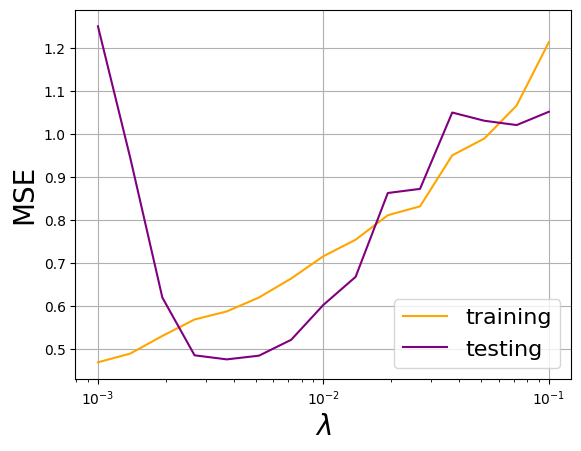

In [ ]:
#choose a range of lambda values across several orders of magnitude
lambdas = np.logspace(-3,-1,15)

training_mse = []
testing_mse = []
parameters = []
for lam in lambdas:
  model = sklearn.linear_model.Lasso(alpha=lam, max_iter=100000)
  model.fit(X_train_standardized, y_train)

  parameters.append(model.coef_)

  y_pred = model.predict(X_train_standardized)
  mse = sklearn.metrics.mean_squared_error(y_train, y_pred)
  training_mse.append(mse)

  y_pred_test = model.predict(X_test_standardized)
  mse = sklearn.metrics.mean_squared_error(y_test, y_pred_test)
  testing_mse.append(mse)

fig,ax = plt.subplots()
ax.plot(lambdas, training_mse, color='orange', label='training')
ax.plot(lambdas, testing_mse, color='purple', label='testing')
ax.set_xlabel('$\\lambda$',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_xscale('log')
ax.legend(fontsize=16)
ax.grid()
plt.show()

Let's see how the parameters change with $\lambda$.

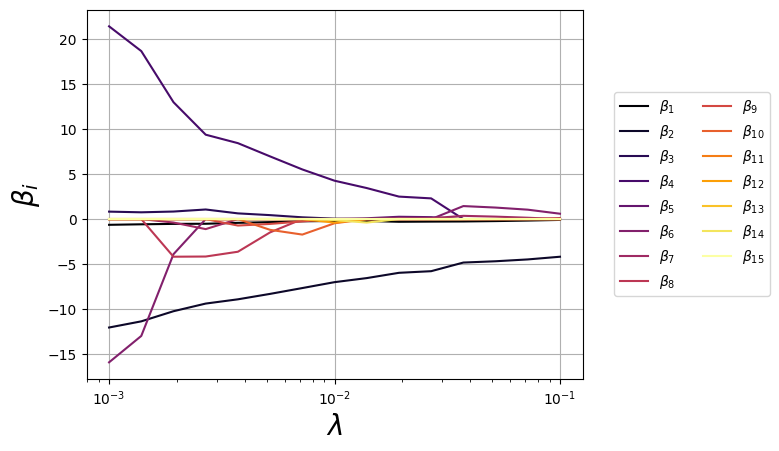

In [ ]:
parameters = np.array(parameters)

fig, ax = plt.subplots()

colormap = cm.inferno
colors = colormap(np.linspace(0.0, 1.0, parameters.shape[0]))

for i, c in enumerate(colors):
  beta = parameters[:,i]
  ax.plot(lambdas, beta, color=c, label='$\\beta_{{{}}}$'.format(i+1))

ax.set_xlabel('$\\lambda$',fontsize=20)
ax.set_ylabel('$\\beta_{i}$',fontsize=20)
ax.set_xscale('log')
ax.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.show()

We can see that with LASSO regression, parameters will get set to 0 exactly.  Previously with ridge regression the parameters would approach 0, but never be 0 exactly.  This is a form of feature selection, where LASSO zeros out the least important features.  Let's look at the optimal model.

Parameters:  [-0.41637345 -8.92281106  0.63653817  8.44792825 -0.         -0.
 -0.         -3.6304916  -0.71764811 -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.        ]


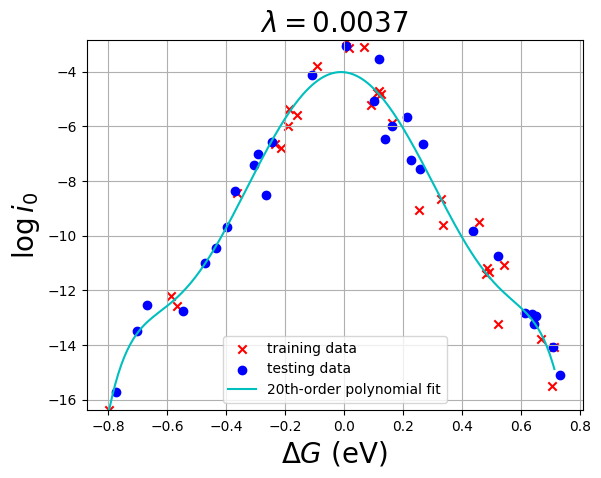

In [ ]:
idx = np.argmin(testing_mse)

model = sklearn.linear_model.Lasso(alpha=lambdas[idx], max_iter=100000)
model.fit(X_train_standardized, y_train)

xplot = np.linspace(np.min(df_train[['dG (eV)']].values), np.max(df_train[['dG (eV)']].values), 300)
Xplot = poly_features.transform(xplot.reshape(-1,1))
Xplot = scaler.transform(Xplot)
yplot = model.predict(Xplot)

print('Parameters: ', model.coef_)

fig,ax = plt.subplots()
plot_data(ax, df_train, 'r', 'x', 'training data')
plot_data(ax, df_test, 'b', 'o', 'testing data')
ax.plot(xplot,yplot,color='c',label='20th-order polynomial fit')
ax.set_ylim(np.min(y_train), np.max(y_train))
ax.set_title('$\\lambda=$'+str(np.round(lambdas[idx], decimals=4)),fontsize=20)
ax.grid()
ax.legend()
plt.show()